# Import Necessary Libraries

In [1]:
! pip install torchmetrics

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.optim as optim
from torchvision.datasets import SVHN
from torch.utils.data import DataLoader, random_split, Dataset
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision
import numpy as np


In [3]:
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Define the Device

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Will run on cuda if available else will run on cpu

# Transformations

In [5]:
transform = transforms.Compose([ # Performing necessary transformations on the dataset
    transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4378, 0.4438, 0.4727], [0.1980, 0.2010, 0.1971])
])

# Define the Hyperparameters

In [6]:
batch_size = 64 # There are 64 samples in each batch
n_epochs = 20

# If m is our batch size and the image size is 32*32 and is coloures ie has 3 colour channels
# The dimension of each batch can be represented as [m, 3, 32, 32]

# Hence the input for the first linear layer of the Encoder will be 3*32*32

input_size = 3*16*16
latent_size = 300
learning_rate = 0.0003

# Loading the Dataset

In [24]:
train_dataset = datasets.SVHN(root='./data', split = "train", transform=transform, download=True) # downloading the train dataset
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.9, 0.1]) # splitting the train dataset into train and val
test_dataset = datasets.SVHN(root='./data', split = "test", transform=transform, download=True) # downloading the test dataset

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


# Making the train, test and val loader

In [25]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)

In [32]:
import numpy as np

def sample_image(test_dataset):
    random_index = np.random.randint(len(train_dataset))
    random_image, random_label = train_dataset[random_index]
    
    # Reshape the image to 1x3x32x32 (CIFAR-10 images are 3x32x32)
    random_image = random_image.unsqueeze(0)
    
    print(random_image.size(0)) #1
    print(random_image.size(1)) #3
    print(random_image.size(2)) #32
    print(random_image.size(3)) #32

    # Create the header file
    with open('/kaggle/working/image.h', 'w') as f:
        f.write('#pragma once\n')
        f.write('#include <vector>\n')
        f.write('using namespace std;\n')
        f.write('vector<vector<vector<vector<float>>>> image = {\n')
        f.write('    {\n')
        for channel in range(random_image.size(1)):
            f.write('    {')
            for row in range(random_image.size(2)):
                f.write('        {')
                for col in range(random_image.size(3)):
                    f.write(f'{random_image[0, channel, row, col].item():.6f}')
                    if col < random_image.size(3) - 1:
                        f.write(', ')
                f.write('}')
                if row < random_image.size(2) - 1:
                    f.write(',\n')
                else:
                    f.write('\n')
            f.write('    }')
            if channel < random_image.size(1) - 1:
                f.write(',\n')
            else:
                f.write('')
        f.write('    }\n')
        f.write('};')

    print('Random image saved to image.h')
    print(f'The label of the image is {random_label}')
    print(f'The shape of the image is {random_image.shape}')


In [33]:
sample_image(test_dataset)

1
3
32
32
Random image saved to image.h
The label of the image is 3
The shape of the image is torch.Size([1, 3, 32, 32])


# Defining the Model

In [26]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.Conv2d(8, 3, kernel_size=3, stride=1, padding=1), 
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Optimizer and Criterion

In [27]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

# Training Loop

In [28]:
train_losses = []
val_losses = []
for epoch in range(n_epochs):

    # Training
    model.train()
    train_loss = 0.0
    for datasamples in train_loader:
        features, _ = datasamples
        features = features.to(device)
        outputs = model(features)
        optimizer.zero_grad()
        t_loss = criterion(outputs, features)
        train_loss+=t_loss.item()
        t_loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for datasamples in val_loader:
            features, _ = datasamples
            features = features.to(device)
            outputs = model(features)
            v_loss = criterion(outputs, features)
            val_loss += v_loss.item()
    train_losses.append(train_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))
    print(f"Epoch: {epoch + 1}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] <= min(val_losses): # If for an epoch the val loss comes out to be the minimum, then we save the state of the model
        torch.save(model.state_dict(), "/kaggle/working/best_model.pth")
        print("Best model updated..")

Epoch: 1, Training Loss: 0.11601073509326094, Validation Loss: 0.024413093373827313
Best model updated..
Epoch: 2, Training Loss: 0.017250580681536697, Validation Loss: 0.013518195194394692
Best model updated..
Epoch: 3, Training Loss: 0.010926940912429593, Validation Loss: 0.009122892222164766
Best model updated..
Epoch: 4, Training Loss: 0.005888792788013671, Validation Loss: 0.004818909969585746
Best model updated..
Epoch: 5, Training Loss: 0.004173813943970663, Validation Loss: 0.003879968886790068
Best model updated..
Epoch: 6, Training Loss: 0.003423659362180735, Validation Loss: 0.0032160952667017345
Best model updated..
Epoch: 7, Training Loss: 0.0028691514766441746, Validation Loss: 0.002899100461407848
Best model updated..
Epoch: 8, Training Loss: 0.002448035218002262, Validation Loss: 0.002316393807489911
Best model updated..
Epoch: 9, Training Loss: 0.0020966216139079847, Validation Loss: 0.00203087254650081
Best model updated..
Epoch: 10, Training Loss: 0.00181577297986261

# Plotting the Traing and Validation Loss curves

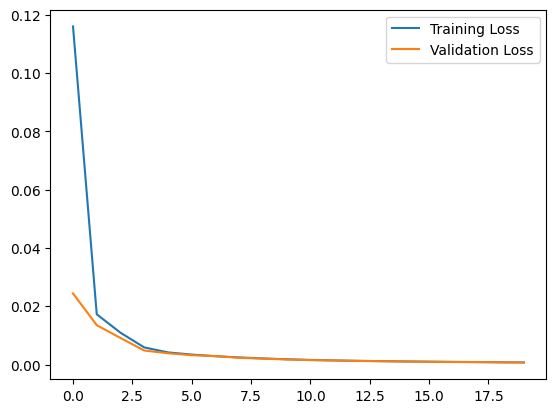

In [29]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [30]:
model_parameters = {}
for name, param in model.named_parameters():
    name = name.replace('.', '_')
    model_parameters[name] = param.cpu().detach().numpy()
    print(f'name is : {name} || shape is {param.shape}')

name is : encoder_0_weight || shape is torch.Size([8, 3, 3, 3])
name is : encoder_0_bias || shape is torch.Size([8])
name is : encoder_2_weight || shape is torch.Size([4, 8, 3, 3])
name is : encoder_2_bias || shape is torch.Size([4])
name is : decoder_0_weight || shape is torch.Size([8, 4, 3, 3])
name is : decoder_0_bias || shape is torch.Size([8])
name is : decoder_2_weight || shape is torch.Size([3, 8, 3, 3])
name is : decoder_2_bias || shape is torch.Size([3])


In [31]:
with open('/kaggle/working/model_params_auto.h', 'w') as f:
    f.write('#ifndef MODEL_PARAMS_H\n')
    f.write('#define MODEL_PARAMS_H\n\n')
    f.write('#include <vector>\n\n')
    f.write('using namespace std;\n\n')
    for name, param in model_parameters.items():
        if "weight" in name:
            shape = param.shape
            f.write(f'const vector<vector<vector<vector<float>>>> {name} = ')
            f.write('{\n')
            for item in param:
                f.write('{')
                for inner_item in item:
                    f.write('{')
                    for sub_item in inner_item:
                        f.write('{')
                        for sub_sub_item in sub_item:
                            f.write(f'{sub_sub_item}, ')
                        f.write('}, ')
                    f.write('}, ')
                f.write('}, ')
            f.write('};\n')
            
        elif "bias" in name:
            shape = param.shape
            f.write(f'const vector<float> {name} = ')
            f.write('{\n')
            for item in param:
                f.write(f'{item}, ')
            f.write('};\n')
    f.write('#endif // MODEL_PARAMS_H\n')